# The provided solution face detection and feature extraction 

This code is provided to you, so you can focus on the goals of this project.

### Step 1: Set the path to example videos and to datasets


In [1]:
# the paths to the actual data can be changed here
real_video = './sa1.avi'
fake_video = './sa1-video-fram1.avi' 
# the paths to the folders where all videos are
real_folder = './VidTIMIT/'
fake_folder = './DeepfakeTIMIT/higher_quality/'  # we focus on high quality videos of DeepfakeTIMIT dataset


### Step 2 Run provided face detection and extraction code

In [2]:
import numpy as np
import glob
import os
import cv2
# some settings to make it smoothly runnable in Jupyter
os.environ['KMP_DUPLICATE_LIB_OK']='True'
%matplotlib inline
import matplotlib.pyplot as plt

def eyes_angle(left_eye, right_eye):
    # find the distances between X and Y coordinates of both eyes
    dY = right_eye[1] - left_eye[1]
    dX = right_eye[0] - left_eye[0]
    # compute the angle using trigonometry
    angle = np.degrees(np.arctan2(dY, dX))
    return angle
    
def scaling_factor(left_eye, right_eye, desired_left_eye, desired_right_eye):
    # find the distances between X and Y coordinates of both eyes
    dY = right_eye[1] - left_eye[1]
    dX = right_eye[0] - left_eye[0]
    # find the actual distance between eyes (the hypotenuse)
    dist = np.sqrt((dX ** 2) + (dY ** 2))
    # find the distance between X and Y coordinates in the desired face (which we will have after scaling)
    desired_dY = desired_right_eye[1] - desired_left_eye[1]
    desired_dX = desired_right_eye[0] - desired_left_eye[0]
    # find the  distance between desired eye coordinates (the hypotenuse)
    desired_dist = np.sqrt((desired_dX ** 2) + (desired_dY ** 2))
    
    # compute the ratio between distances, which is the scale factor
    scaling_factor = desired_dist / dist
    return scaling_factor
    

def crop_and_align(image, left_eye, right_eye, desired_image_width, 
                   desired_left_eye_percentage):
    # find angle of the line between the eyes
    angle = eyes_angle(left_eye, right_eye)

    # assuming desired_left_eye_percentage tells where the eyes should be relative to the image size
    # compute its actual place in the resulted image
    desired_left_eye = (desired_left_eye_percentage[0]*desired_image_width, 
                        desired_left_eye_percentage[1]*desired_image_width)
    # similar compute the mirror coordinates for desired_right_eye
    desired_right_eye = ((1.0-desired_left_eye_percentage[0])*desired_image_width, 
                        desired_left_eye_percentage[1]*desired_image_width)

    # find scaling factor based on where we want our eyes to be in the resulted image
    scale = scaling_factor(left_eye, right_eye, desired_left_eye, desired_right_eye)
    
    # find the center point between two eyes, around which we will rotate the image
    eyes_center = ((left_eye[0] + right_eye[0]) // 2, (left_eye[1] + right_eye[1]) // 2)

    # compute the rotation matrix using OpenCV, rotate and scale around the eyes_center
    M = cv2.getRotationMatrix2D(eyes_center, angle, scale)

    # move the current center of the eyes to the desired coordinates, which are
    # mid point horizontally and the desired level vertically
    tX = desired_image_width * 0.5
    tY = desired_left_eye[1]
    M[0, 2] += (tX - eyes_center[0])
    M[1, 2] += (tY - eyes_center[1])

    # by specifying height and width of the final image
    # as our desired_image_width, we insruct warpAffine to cut off the extra pixels
    w = desired_image_width
    h = desired_image_width

    # using OpenCV warpAffine() apply the M transformation, which will also crop the image
    aligned = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC)
    return aligned

from mtcnn import MTCNN
detector = MTCNN()

# detect one face and its eyes coordinates in the given image
def detect_face(image, desired_size=224, desired_left_eye_percentage=(0.35, 0.35)):
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    detection_result = detector.detect_faces(image_rgb)
    left_eye = detection_result[0]['keypoints']['left_eye']
    right_eye = detection_result[0]['keypoints']['right_eye']
    face = crop_and_align(image, left_eye, right_eye, desired_size, desired_left_eye_percentage)
    if face is not None:
        return face
    return None

# loop through frames in the video and detect faces
def detect_and_save_faces(video_path, limit_faces=-1, save_faces=True):
    detector = MTCNN()
    faces = list()
    # add '_face' at the end to differentiate face images
    face_name = os.path.splitext(video_path)[0] + '_face'
    
    cap = cv2.VideoCapture(video_path)
    num_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    for frame_no in range(num_frames):
        # if the given limit is not -1, loop only until the limit
        if limit_faces != -1 and frame_no >= limit_faces:
            break
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_no)
        ret, frame = cap.read()
        # detect faces
        face = detect_face(frame, desired_size=256, desired_left_eye_percentage=(0.35, 0.35))
        if face is not None:
            faces.append(face)
            if save_faces:
                cv2.imwrite(face_name + '_' + str(frame_no) + '.png', face)
    return faces



Using TensorFlow backend.


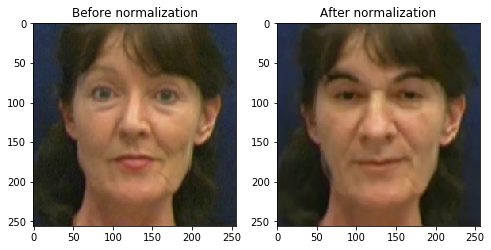

In [3]:
# running provided code on one real and one fake video
real_faces = detect_and_save_faces(real_video, limit_faces=5)
fake_faces = detect_and_save_faces(fake_video, limit_faces=5)

# convert the list of faces to the numpy array
# define a function that will read and display given images
def display_images_side_by_side(im1, im2):
    # note that images in OpenCV are in BGR format, 
    # and to plot with matplotlib, we convert them to RGB
    im1 = cv2.cvtColor(im1, cv2.COLOR_BGR2RGB)
    im2 = cv2.cvtColor(im2, cv2.COLOR_BGR2RGB)

    # show the images side by side
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(im1)
    plt.title('Before normalization')
    plt.subplot(1, 2, 2)
    plt.title('After normalization')
    plt.imshow(im2)
    plt.show()

# plot real and fake faces side by side
display_images_side_by_side(real_faces[0], fake_faces[0])

### Step 3 Run provided code for computing features

Run code and compute features for two faces, as an example

In [4]:
import skimage.metrics
num_hist_bins = 32

# Note that the number of bins we use for the histogram is a parameter of the system
# more bins - more features
def compute_hist(image, num_bins=32):
    hist, bins = np.histogram(image.ravel(), num_bins, [0,255], density=True)
    return hist


def compute_blurred_image(image, kernel_size=3, sigma=0.5):
    return cv2.GaussianBlur(image, (kernel_size, kernel_size), sigma)

def mse(x, y):
    return skimage.metrics.normalized_root_mse(x, y)

def psnr(x, y):
    return skimage.metrics.peak_signal_noise_ratio(x, y, data_range=255)

def ssim(x, y):
    return skimage.metrics.structural_similarity(x, y, multichannel=True, 
                                                 gaussian_weights=True, sigma=1.5, 
                                                 use_sample_covariance=False, data_range=255)

def compute_features(image):
    image_blurred = compute_blurred_image(image)
    im_ssim = ssim(image, image_blurred)
    im_mse = mse(image, image_blurred)
    im_psnr = psnr(image, image_blurred)
    im_hist = compute_hist(image, num_bins=num_hist_bins)
    features = np.concatenate([[im_ssim], [im_mse], [im_psnr], im_hist])
    return features

# as an example, compute features just for one real and one fake faces
real_feature = compute_features(real_faces[0])
fake_feature = compute_features(fake_faces[0])
print("Real feature vector:\n {} \nof length {}".format(real_feature, len(real_feature)))
print("Deepfake feature vector:\n {} \nof length {}".format(fake_feature, len(fake_feature)))

# notice the last values in both case are zeros, 
# that's because these face have not bright pixels with values near 255,
# so, the last bin of the histogram becomes empty 

Real feature vector:
 [9.98161073e-01 5.68581474e-03 5.40556277e+01 2.19566993e-04
 1.39208027e-03 6.05915543e-03 9.67754289e-03 1.59064798e-02
 1.56996783e-02 1.05455984e-02 5.74065564e-03 6.01639093e-03
 6.40127145e-03 6.18489583e-03 5.17641953e-03 4.41495609e-03
 3.60179228e-03 3.60306883e-03 4.13156148e-03 4.24645118e-03
 2.93670854e-03 2.57480596e-03 2.13120404e-03 1.95631638e-03
 1.98376225e-03 1.32889093e-03 9.12734886e-04 8.12525531e-04
 7.32102737e-04 4.76154003e-04 2.91692198e-04 2.19566993e-04
 1.11060049e-04 5.10620915e-06 0.00000000e+00] 
of length 35
Deepfake feature vector:
 [9.98961883e-01 4.89882520e-03 5.55207126e+01 3.35094975e-04
 2.38013174e-03 7.08997141e-03 9.87349367e-03 1.74568525e-02
 1.53211806e-02 9.00862949e-03 5.36215788e-03 6.32021038e-03
 6.43765319e-03 5.88299122e-03 5.02833946e-03 4.21772876e-03
 3.59732435e-03 3.64391850e-03 4.21389910e-03 3.52456087e-03
 2.81671262e-03 2.43310866e-03 2.19439338e-03 2.01886744e-03
 1.67738971e-03 1.32952921e-03 7.9848